In [1]:
#see, 
# https://github.com/HamedAlemo/visualize-goes16/blob/master/visualize_GOES16_from_AWS.ipynb
# https://registry.opendata.aws/noaa-goes/

In [2]:
!pip install netCDF4

     |████████████████████████████████| 4.7MB 5.6MB/s 
     |████████████████████████████████| 317kB 24.5MB/s 


In [3]:
!pip install boto3

     |████████████████████████████████| 133kB 4.1MB/s 
     |████████████████████████████████| 81kB 6.3MB/s 
     |████████████████████████████████| 7.4MB 25.5MB/s 
     |████████████████████████████████| 153kB 52.6MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [4]:
import xarray as xr
import requests
import netCDF4
import boto3
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.4) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [5]:
bucket_name = 'noaa-goes16'
product_name = 'ABI-L1b-RadF'
year = 2019
day_of_year = 79
hour = 1
band = 1

In [6]:
# Initialize s3 client. 
s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))

In [7]:
def get_s3_keys(bucket, s3_client, prefix = ''):
    """
    Generate the keys in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch keys that start with this prefix (optional).
    """
    
    kwargs = {'Bucket': bucket}

    if isinstance(prefix, str):
        kwargs['Prefix'] = prefix

    while True:
        resp = s3_client.list_objects_v2(**kwargs)
        for obj in resp['Contents']:
            key = obj['Key']
            if key.startswith(prefix):
                yield key

        try:
            kwargs['ContinuationToken'] = resp['NextContinuationToken']
        except KeyError:
            break

In [8]:
keys = get_s3_keys(bucket_name,
                   s3_client,
                   prefix = f'{product_name}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M3C{band:02.0f}'
                  )

key = [key for key in keys][0] # selecting the first measurement taken within the hour

In [9]:
resp = requests.get(f'https://{bucket_name}.s3.amazonaws.com/{key}')
print(f'https://{bucket_name}.s3.amazonaws.com/{key}')

https://noaa-goes16.s3.amazonaws.com/ABI-L1b-RadF/2019/079/01/OR_ABI-L1b-RadF-M3C01_G16_s20190790100364_e20190790111130_c20190790111179.nc


In [10]:
file_name = key.split('/')[-1].split('.')[0]
print(file_name)
nc4_ds = netCDF4.Dataset(file_name, memory = resp.content)
store = xr.backends.NetCDF4DataStore(nc4_ds)
DS = xr.open_dataset(store)

OR_ABI-L1b-RadF-M3C01_G16_s20190790100364_e20190790111130_c20190790111179


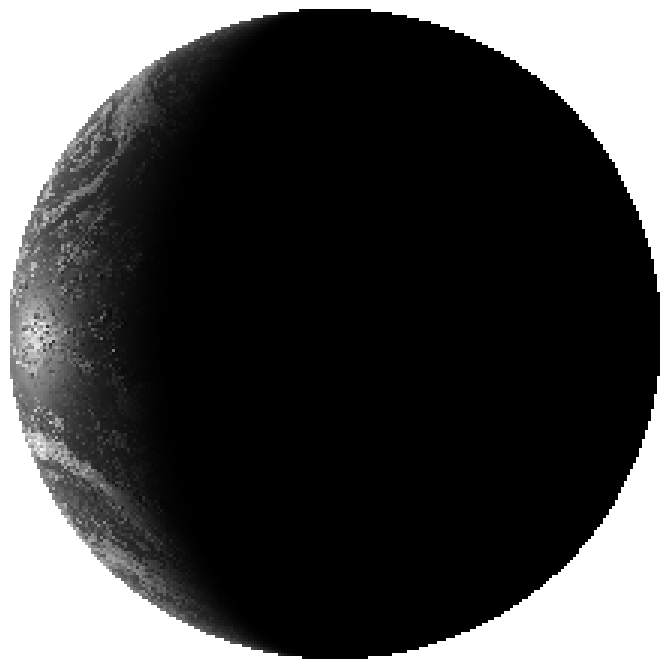

In [11]:
fig = plt.figure(figsize=(12, 12))
plt.imshow(DS.Rad[::50,::50], cmap='gray')
plt.axis('off')
plt.show()
# plt.savefig(f'{file_name}.png', dpi=300, facecolor='w', edgecolor='w')